In [2]:
%load_ext autoreload
import sys
sys.path.append("..")

In [3]:
import sys
sys.path.append("..")
sys.path.append("../..")

import numpy as np
import copy
import pickle
import csv
from scipy.interpolate import interp1d
from scipy.stats import chi2
from scipy import optimize

import darkhistory.physics as phys
from darkhistory.history.tla import get_history
from darkhistory.history import tla
import darkhistory.history.reionization as reion
from tqdm import tqdm_notebook as tqdm


import main
import config

In [4]:
output_dir = '/Users/gregoryridgway/Desktop/Junk/'
input_dir = '/Users/gregoryridgway/Dropbox (MIT)/Late_Time_Energy_Injection/'

### Reionization Data

In [5]:
reion_strings = np.array(
    ['earliest', 'latest', 'FlexKnot_early', 'FlexKnot_late','FlexKnot_early_1sig', 'FlexKnot_late_1sig', 'Tanh_early', 'Tanh_late', 'Tanh_early_1sig', 'Tanh_late_1sig']
)

def make_reion_interp_func(string, He_bump=False):
    Planck_data = []
    with open(input_dir+'reion_models/Planck_'+
              string+'.csv') as csvfile:
        reader = csv.reader(csvfile)
        reader = csv.reader(csvfile)
        for row in reader:
            Planck_data.append([float(row[0]),float(row[1])])
    Planck_data = np.array(Planck_data)

    #fix normalization
    if string == 'FlexKnot_early':
        norm_fac = Planck_data[-2,1]
    else:
        norm_fac = Planck_data[0,1]
        
        #I WebPlot Digitized poorly, so I re-zero
        if string == 'FlexKnot_late':
            Planck_data[26:,1] = 0
        elif string == 'Tanh_late':
            Planck_data[63:,1] = 0
            
        
    Planck_data[:,1] = (1+2*phys.chi)*Planck_data[:,1]/norm_fac

    #convert from z to rs
    Planck_data[:,0] = 1+Planck_data[:,0]

    fac = 2
    if He_bump == False:
        Planck_data[Planck_data[:,1]>1+phys.chi,1]=1+phys.chi
        fac = 1

    return interp1d(Planck_data[:,0], Planck_data[:,1], 
                    bounds_error=False, fill_value=(1+fac*phys.chi,0), kind='linear')

# Make interpolation functions for each Planck2018 reionization history
reion_interps = {string : make_reion_interp_func(string) for string in reion_strings}
bump_interp = make_reion_interp_func('Tanh_late', True)

### Ly$\alpha$ data

In [6]:
ind = -7

z_entries=np.array([1.8,2.0,2.2,2.4,2.6,2.8,3.0,3.2,3.4,3.6,3.8,4.0,4.2,4.6,5.0,5.4])
rs_entries=1+z_entries[ind:]

new_mids=np.array([.768,.732,1.014,1.165,1.234,
          1.286,1.289,1.186,1.404,1.038,
          1.205,.940,.890,.877,.533,.599])
mids = new_mids[ind:]

high_errs = np.array([.37,.17,.25,.29,.19,.19,.18,.13,.17,.31,.23,.22,.093,.13,.12,.15])
low_errs  = np.array([.22,.091,.15,.19,.14,.15,.14,.12,.16,.27,.19,.17,.073,.11,.091,.13])
sigs = low_errs[ind:]

Gaikwad_data = np.array([[1.1, .16], [1.05, .21], [1.2, .22]])
Gaikwad_rs   = np.array([6.4,6.6,6.8])

default_data = [
    np.concatenate((rs_entries[:-2], Gaikwad_rs)),
    (
        np.concatenate((mids[:-2], Gaikwad_data[:,0])),
        np.concatenate((high_errs[ind:-2], Gaikwad_data[:,1]))
    )
]

### Previous Constraints

In [7]:
Hongwan_data = pickle.load(open(input_dir+'/data/constraints code/compiled_data.p','rb'))

### Functions for photoheating constraints

In [8]:
rs_vec = 10**np.arange(np.log10(2.9e3), np.log10(4.55), -.01)

#Given DeltaT and alpha, return the temperature in 10^-4 K
def get_his(DeltaT, alpha, mDM=None, lifetime=None, sigmav=None, DM_process='decay',
            fs=[None, None, None, None], reion_method='FlexKnot_early'):
    
    if sigmav is not None:
        struct_boost = phys.struct_boost_func(model='pwave_NFW_no_subs')
    elif lifetime is not None:
        struct_boost = None
    else:
        struct_boost = None
        DM_process   = None
        
    tmp = tla.get_history(
        rs_vec,
        DM_process = DM_process, mDM=mDM, lifetime=lifetime, sigmav=sigmav,
        struct_boost = struct_boost,
        f_H_ion=fs[0], f_He_ion=fs[1], f_H_exc=fs[2], f_heating=fs[3],
        reion_switch=True, reion_rs=35, reion_method=None, 
        heat_switch=True, DeltaT = DeltaT, alpha_bk=alpha,
        xe_reion_func=reion_interps[reion_method], helium_TLA=True
    )
    return interp1d(rs_vec, tmp[:,0]/phys.kB*1e-4)

#Given DeltaT and alpha, find (two-sided) chi^2
def get_chisq(var, mDM=None, lifetime=None, sigmav=None, DM_process='decay',
              fs=[None, None, None, None], reion_method='FlexKnot_early'):
    DeltaT = var[0]
    alpha=var[1]
    terp = get_his(DeltaT, alpha, mDM=mDM, lifetime=lifetime, sigmav=sigmav, 
                   DM_process = DM_process, fs=fs, reion_method=reion_method)
    return sum((terp(default_data[0])-default_data[1][0])**2/default_data[1][1]**2)

#Given alpha, optimize DeltaT
def optimize_DeltaT(alpha, tol, mDM=None, lifetime=None, sigmav=None, 
                    DM_process = 'decay', fs=[None, None, None, None], reion_method='FlexKnot_early'):
    def f(DeltaT):
        return get_chisq([DeltaT,alpha], mDM=mDM, lifetime=lifetime, sigmav=sigmav, 
                         DM_process=DM_process, fs=fs, reion_method=reion_method)

    return optimize.minimize_scalar(
        f, method='bounded', bounds=[0*phys.kB, 5e4*phys.kB], options={'xatol': tol}
    )

def find_optimum(alpha_list, init, tol=0.5, mDM=None, lifetime=None, 
                 DM_process = 'decay', sigmav=None, fs=[None, None, None, None], output=False, reion_method='FlexKnot_early'):
    datums = [None for a in alpha_list]
    check_above = False
    check_below = False

    #Initialization Step
    j = init
    out = optimize_DeltaT(alpha_list[j], tol, mDM=mDM, lifetime=lifetime, sigmav=sigmav, 
                          DM_process=DM_process, fs=fs, reion_method=reion_method)
    datums[j] = [alpha_list[j], out['x']/phys.kB, out['fun']]
    count = 0
    
    #Search higher alpha
    while not check_above:
        count = count+1
        #At this point, you know the optimal value is above
        if count>1:
            check_below = True

        j = j+1
        out = optimize_DeltaT(alpha_list[j], tol, mDM=mDM, lifetime=lifetime, sigmav=sigmav,
                              DM_process=DM_process, fs=fs, reion_method=reion_method)
        datums[j] = [alpha_list[j], out['x']/phys.kB, out['fun']]
        if output:
            print(datums[j])


        if datums[j][2] > datums[j-1][2]:
            check_above=True
            j = j-1
            break
        elif j==alpha_list.size-1:
            if output:
                print('Reached maximum alpha!', datums[j])
            return np.array([datums[j],datums[j],datums[j]])
            

    #Search lower alpha
    while not check_below:
        j = j-1
        out = optimize_DeltaT(alpha_list[j], tol, mDM=mDM, lifetime=lifetime, sigmav=sigmav,
                              DM_process=DM_process, fs=fs, reion_method=reion_method)
        datums[j] = [alpha_list[j], out['x']/phys.kB, out['fun']]

        if output:
            print(datums[j])
        if datums[j][2] > datums[j+1][2]:
            check_below=True
            j = j+1
        elif j==0:
            if output:
                print('Reached minimum alpha!', datums[j])
            return np.array([datums[j],datums[j],datums[j]])
            
#     if output:
    print('Best value: ', datums[j])
#     #filter out all the None entries
#     return list(filter(None,datums))
    return np.array([datums[j-1], datums[j], datums[j+1]])


#Make the f functions
def make_fs(hist, pickleable = False):
    channels = {'heat', 'H ion', 'He ion', 'exc'}
    f_interps = {chan: interp1d(
        hist['rs'], 
        hist['f']['low'][chan]+hist['f']['high'][chan],
        bounds_error=False,
        fill_value=(
            (hist['f']['low'][chan]+hist['f']['high'][chan])[-1],
            (hist['f']['low'][chan]+hist['f']['high'][chan])[0]
        )
    ) for chan in channels}
    
    def f_Hion(rs, xHI, xHeI, xHeII):
        return f_interps['H ion'](rs)
    def f_Heion(rs, xHI, xHeI, xHeII):
        return f_interps['He ion'](rs)
    def f_exc(rs, xHI, xHeI, xHeII):
        return f_interps['exc'](rs)
    def f_heat(rs, xHI, xHeI, xHeII):
        return f_interps['heat'](rs)
     
    if pickleable:
        return f_interps
    else:
        return [f_Hion, f_Heion, f_exc, f_heat]

## Generate Constraints

In [9]:
max_chisq = 10.1522
def find_param_guess(mDM, log10guess, inc, data, heat_switch=False, 
                     reion_method='FlexKnot_early',pri = 'elec', DM_process = 'decay', 
                     DeltaT=24665*phys.kB, alpha_bk=0.57):
    """
    Parameters
    ----------
    inc : float
        amount by which to increment the log10(parameter)
    DeltaT : float
        photoheating parameter, set to best fit value in the absence of DM
    alpha_bk : float
        photoheating parameter, set to best fit value in the absence of DM
    
    """
    below_target = False
    above_target = False
    chisq_list = []
    log10params = [log10guess]
    
    while (
        not below_target or not above_target
    ):

        if DM_process=='pwave':
            sign=-1.0
            struct_boost = phys.struct_boost_func(model='pwave_NFW_no_subs')
        else:
            sign = 1.0
            struct_boost = None
            
        param = 10**log10params[-1]
        print('log10param: '+str(log10params[-1]))

        base_hist = main.evolve(
            primary=pri+'_delta',
            DM_process=DM_process, mDM=mDM, lifetime=param, sigmav=param,
            reion_switch=True, reion_rs=35, helium_TLA=True,
            xe_reion_func = reion_interps[reion_method],
            start_rs = 3e3, end_rs=4.3, DeltaT = DeltaT, 
            alpha_bk=alpha_bk, heat_switch=heat_switch,
            coarsen_factor=12, backreaction=True, 
            compute_fs_method='He', mxstep=1000, rtol=1e-4,
            use_tqdm=True, cross_check = False,
            struct_boost=struct_boost
        )
        ###!!! This is the line that saves the f's
        log10m_str = str(round(np.log10(mDM)*100)/100)
        log10param_str = str(round(log10params[-1]*100)/100)
        
        f_interps = make_fs(base_hist, pickleable=True)
        pickle.dump(f_interps, open(
            output_dir+'mainEvolveOutput_'+reion_method+'_'+pri+'_'+DM_process
            +'log10mDM'+log10m_str+'_log10param'+log10param_str+'.dat','wb'
        ))
        
        if not heat_switch:
            Tm_interp = interp1d(base_hist['rs'], base_hist['Tm']/phys.kB*1e-4)
            diff = Tm_interp(data[0]) - data[1][0]
            diff[diff<0] = 0
            chisq = sum((diff/data[1][1])**2)
        else:
            fs = make_fs(base_hist)
            alpha_list = np.arange(-0.5,1.5,0.1)
            data = find_optimum(alpha_list, init=10, mDM=mDM, DM_process=DM_process,
                                lifetime=param, sigmav=param, fs=fs)
            chisq = data[1][-1]
        
        chisq_list.append(chisq)
        print('Test Statistic: {:03.1e}'.format(chisq))

        nan_flag = np.any(np.isnan(base_hist['Tm']))
        if nan_flag:
            print('NAN! increasing heating rate.')
            log10params.append(log10params[-1]-inc*sign)
        elif chisq < max_chisq:
            below_target = True
            log10params.append(log10params[-1]-inc*sign)
        elif chisq > max_chisq:
            above_target = True
            log10params.append(log10params[-1]+inc*sign)

    tau_interp = interp1d(chisq_list, log10params[:-1])
    return tau_interp(max_chisq), chisq_list, log10params

This function below will write out all of the f interpolation functions and save them in output_dir

In [10]:
# Set to False for robust constraints, set to true for photoheating
heat_switch=True
m_inc   = 0.25
tau_inc = 0.25

for DM_process in ['pwave', 'pwave']:
    for pri in ['elec', 'phot']:
        for reion_method in ['Tanh_early', 'Tanh_late', 'FlexKnot_early', 'FlexKnot_late']:

            if reion_method[-4:] == 'late':
                time_str = 'late'
            else:
                time_str = 'early'
            
            
            if DM_process == 'decay':
                param_str = 'taus'
                sign=1
            else:
                param_str='sigmav_over_ms'
                sign=-1
                
            string = pri+'_'+DM_process+'_'+reion_method[:4]+'_'+time_str

            if heat_switch:
                constr_str = 'photoheating'
            else:
                constr_str = 'robust'

            if pri=='phot':
                log10m = np.arange(4.01, 12.76, m_inc)
            else:
                log10m = np.arange(6.01, 12.76, m_inc)
            max_chisq_list = np.zeros_like(log10m)
            data = [[None for k in max_chisq_list], [None for k in max_chisq_list]]
            for i, log10mDM in enumerate(log10m):
                    print('****** log10(mDM): ', log10mDM, ' ******')
                    mDM = 10**log10mDM
                    
                    log10guess = interp1d(Hongwan_data[string]['log10m'],
                      Hongwan_data[string][param_str]
                     )(log10mDM)
                    
                    if DM_process == 'pwave':
                        log10guess = log10guess+log10mDM - 9

                    max_chisq_list[i], tmp_chisq_list, tmp_param_list  = find_param_guess(
                        mDM, log10guess, tau_inc, default_data, heat_switch=heat_switch,
                        DM_process = DM_process,
                        reion_method=reion_method, pri=pri
                    )
                    data[0][i] = tmp_chisq_list
                    data[1][i] = tmp_param_list

            pickle.dump(data, open(output_dir+'data_'+constr_str+'_'+reion_method+'_'+pri+'_'+DM_process+'.dat','wb'))

****** log10(mDM):  6.01  ******
log10param: -26.23906883848987
****** Loading transfer functions... ******
    for propagating photons...   Done!
    for low-energy photons...  Done!
    for low-energy electrons...  Done!
    for high-energy deposition...  Done!
    for total upscattered CMB energy rate...  Done!
****** Loading complete! ******
****** Loading transfer functions... ******
    for inverse Compton (Thomson)...  Done!
    for inverse Compton (relativistic)...  Done!
    for inverse Compton (energy loss)...  Done!
****** Loading complete! ******



Test Statistic: 2.8e+37
log10param: -26.48906883848987


KeyboardInterrupt: 

In [50]:
%autoreload
tmp_hist = main.evolve(
    primary='elec_delta',
    DM_process='pwave', mDM=10**6.01, sigmav=10**(-26.48906883848987),
    reion_switch=True, reion_rs=35, helium_TLA=True,
    xe_reion_func = reion_interps['Tanh_early'],
    start_rs = 3e3, end_rs=4.3, DeltaT=24665*phys.kB, alpha_bk=0.57,
    heat_switch=False,
    coarsen_factor=12, backreaction=True, 
    compute_fs_method='He', mxstep=1000, rtol=1e-4,
    use_tqdm=True, cross_check = False,
    struct_boost=phys.struct_boost_func(model='pwave_NFW_no_subs')
)

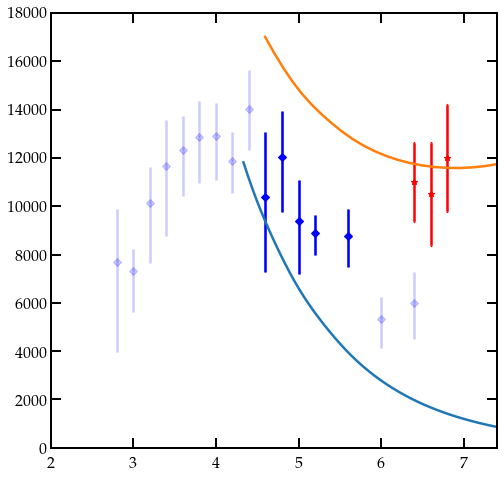

In [66]:
plt.figure(figsize=(8,8))

plt.axis([2,7.4,0,1.8e4])
plt_ind = -7
plotline1, cap1, barlinecols1 = plt.errorbar(1+z_entries, new_mids*1e4, yerr=high_errs*1e4, 
             uplims=True, fmt='D', alpha=0.2, color='blue', capsize=0.1, capthick=0.1)
plotline2, cap2, barlinecols2 = plt.errorbar(1+z_entries, new_mids*1e4, yerr=low_errs*1e4,  
             lolims=True, fmt=',', alpha=0.2, color='blue', capsize=0.1, capthick=0.1)

plotline3, cap3, barlinecols3 = plt.errorbar(1+z_entries[plt_ind:-2], new_mids[plt_ind:-2]*1e4, yerr=high_errs[plt_ind:-2]*1e4, 
             uplims=True, fmt='D', color='blue', capsize=0.1, capthick=0.1)
plotline4, cap4, barlinecols4 = plt.errorbar(1+z_entries[plt_ind:-2], new_mids[plt_ind:-2]*1e4, yerr=low_errs[plt_ind:-2]*1e4,  
             lolims=True, fmt=',', color='blue', capsize=0.1, capthick=0.1)


plotlineG1, cap2, barlinecols2 = plt.errorbar(Gaikwad_rs, Gaikwad_data[:,0]*1e4, yerr=Gaikwad_data[:,1]*1e4,  
             lolims=True, fmt='*', color='red', capsize=0.9, capthick=0.9)
plotlineG1, cap2, barlinecols2 = plt.errorbar(Gaikwad_rs, Gaikwad_data[:,0]*1e4, yerr=Gaikwad_data[:,1]*1e4,  
             uplims=True, fmt='*', color='red', capsize=0.9, capthick=0.9)
plt.plot(tmp_hist['rs'], tmp_hist['Tm']/phys.kB)
plt.plot(rs_vec, tmp_hist2(rs_vec)*1e4)

In [65]:
def get_his(DeltaT, alpha, mDM=None, lifetime=None, sigmav=None, DM_process='decay',
            fs=[None, None, None, None], reion_method='FlexKnot_early'):
    
    if sigmav is not None:
        struct_boost = phys.struct_boost_func(model='pwave_NFW_no_subs')
    elif lifetime is not None:
        struct_boost = None
    else:
        struct_boost = None
        DM_process   = None
        
    tmp = tla.get_history(
        rs_vec,
        DM_process = DM_process, mDM=mDM, lifetime=lifetime, sigmav=sigmav,
        struct_boost = struct_boost,
        f_H_ion=fs[0], f_He_ion=fs[1], f_H_exc=fs[2], f_heating=fs[3],
        reion_switch=True, reion_rs=35, reion_method=None, 
        heat_switch=True, DeltaT = DeltaT, alpha_bk=alpha,
        xe_reion_func=reion_interps[reion_method], helium_TLA=True
    )
    return interp1d(rs_vec, tmp[:,0]/phys.kB*1e-4)

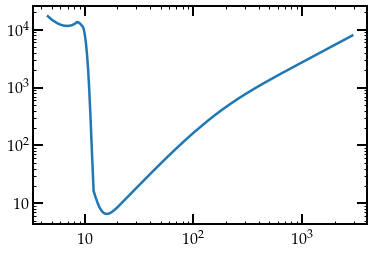

In [64]:
plt.figure()
plt.loglog()
plt.plot(rs_vec, tmp_hist2(rs_vec)*1e4)

In [63]:
fs = make_fs(tmp_hist)

tmp_hist2 = get_his(DeltaT=24665*phys.kB, alpha=0.57, mDM=10**6.01, sigmav=10**(-26.48906883848987), DM_process='pwave',
            fs=fs, reion_method='Tanh_early')

In [36]:
phys.struct_boost_func(model='pwave_NFW_no_subs')(5)

6.039163639995031e+17

In [82]:
robust_hist = main.evolve(
    primary='elec_delta',
    DM_process='decay', mDM=10**log10mDM, lifetime=10**log10guess,
    reion_switch=True, reion_rs=35, helium_TLA=True,
    xe_reion_func = reion_interps['Tanh_early'],
    start_rs = 3e3, end_rs=4.3, DeltaT = 24815*phys.kB, 
    alpha_bk=0.6, heat_switch=False,
    coarsen_factor=12, backreaction=True, 
    compute_fs_method='He', mxstep=1000, rtol=1e-4,
    use_tqdm=True, cross_check = False,
    struct_boost=None
)

In [83]:
photoheat_hist = main.evolve(
    primary='elec_delta',
    DM_process='decay', mDM=10**log10mDM, lifetime=10**log10guess,
    reion_switch=True, reion_rs=35, helium_TLA=True,
    xe_reion_func = reion_interps['Tanh_early'],
    start_rs = 3e3, end_rs=4.3, DeltaT = 24815*phys.kB, 
    alpha_bk=0.6, heat_switch=True,
    coarsen_factor=12, backreaction=True, 
    compute_fs_method='He', mxstep=1000, rtol=1e-4,
    use_tqdm=True, cross_check = False,
    struct_boost=None
)

In [93]:
fs = make_fs(photoheat_hist)
get_chisq(var=[24815*phys.kB, 0.6], mDM=10**log10mDM, lifetime=10**log10guess,
              fs=fs, reion_method='Tanh_early')

149.97757706625998

Text(0.5, 0, 'IGM Temperature, $T_m$')

/usr/local/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


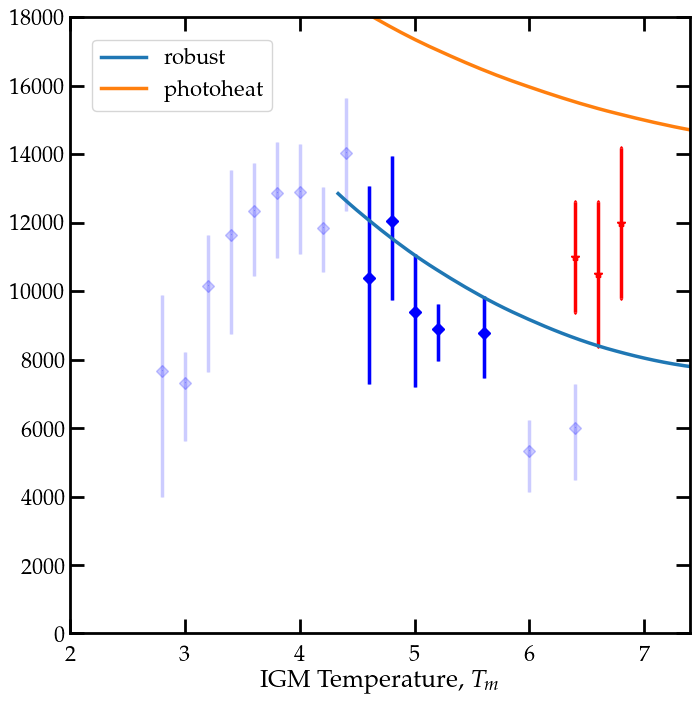

In [84]:
plt.figure(figsize=(8,8))

plt.axis([2,7.4,0,1.8e4])
plt_ind = -7
plotline1, cap1, barlinecols1 = plt.errorbar(1+z_entries, new_mids*1e4, yerr=high_errs*1e4, 
             uplims=True, fmt='D', alpha=0.2, color='blue', capsize=0.1, capthick=0.1)
plotline2, cap2, barlinecols2 = plt.errorbar(1+z_entries, new_mids*1e4, yerr=low_errs*1e4,  
             lolims=True, fmt=',', alpha=0.2, color='blue', capsize=0.1, capthick=0.1)

plotline3, cap3, barlinecols3 = plt.errorbar(1+z_entries[plt_ind:-2], new_mids[plt_ind:-2]*1e4, yerr=high_errs[plt_ind:-2]*1e4, 
             uplims=True, fmt='D', color='blue', capsize=0.1, capthick=0.1)
plotline4, cap4, barlinecols4 = plt.errorbar(1+z_entries[plt_ind:-2], new_mids[plt_ind:-2]*1e4, yerr=low_errs[plt_ind:-2]*1e4,  
             lolims=True, fmt=',', color='blue', capsize=0.1, capthick=0.1)


plotlineG1, cap2, barlinecols2 = plt.errorbar(Gaikwad_rs, Gaikwad_data[:,0]*1e4, yerr=Gaikwad_data[:,1]*1e4,  
             lolims=True, fmt='*', color='red', capsize=0.9, capthick=0.9)
plotlineG1, cap2, barlinecols2 = plt.errorbar(Gaikwad_rs, Gaikwad_data[:,0]*1e4, yerr=Gaikwad_data[:,1]*1e4,  
             uplims=True, fmt='*', color='red', capsize=0.9, capthick=0.9)

plt.plot(robust_hist['rs'], robust_hist['Tm']/phys.kB, label='robust')
plt.plot(photoheat_hist['rs'], photoheat_hist['Tm']/phys.kB, label='photoheat')

plt.legend()
plt.xlabel(r'Redshift, $1+z$')
plt.xlabel(r'IGM Temperature, $T_m$')

In [86]:
Tm_interp = interp1d(robust_hist['rs'], robust_hist['Tm']/phys.kB*1e-4)
diff = Tm_interp(default_data[0]) - default_data[1][0]
diff[diff<0] = 0
robust_chisq = sum((diff/default_data[1][1])**2)


Tm_interp = interp1d(photoheat_hist['rs'], photoheat_hist['Tm']/phys.kB*1e-4)
diff = Tm_interp(default_data[0]) - default_data[1][0]
# diff[diff<0] = 0
photoheat_chisq = sum((diff/default_data[1][1])**2)
    
#     fs = make_fs(base_hist)
#     alpha_list = np.arange(-0.5,1.5,0.1)
#     data = find_optimum(alpha_list, init=10, mDM=mDM, DM_process=DM_process,
#                         lifetime=param, sigmav=param, fs=fs)
#     chisq = data[1][-1]

In [87]:
print(robust_chisq, photoheat_chisq)

4.921230391572364 152.43411311573837


In [ ]:
Tm_interp = interp1d(photoheat_hist['rs'], photoheat_hist['Tm']/phys.kB*1e-4)
diff = Tm_interp(data[0]) - data[1][0]
# diff[diff<0] = 0
robust_chisq = sum((diff/data[1][1])**2)

# OLD

## Notebook Initialization

In [1]:
%load_ext autoreload
import sys
sys.path.append("..")

In [2]:
%matplotlib inline

In [3]:
%autoreload

import matplotlib
matplotlib.rc_file('matplotlibrc')
import matplotlib.pyplot as plt

from astropy.io import fits

import numpy as np
import copy
import pickle
from tqdm import tqdm_notebook as tqdm
from scipy.interpolate import interp1d


import darkhistory.physics as phys
import darkhistory.spec.spectools as spectools
from darkhistory.history.tla import get_history

import main

## Ly$\alpha$ Forest Temperature Measurements

In [4]:
import config
from scipy.interpolate import interp2d

In [13]:
input_dir = '/Users/gregoryridgway/Dropbox (MIT)/Late_Time_Energy_Injection/reion_models/'
output_dir = '/Users/gregoryridgway/Desktop/'

In [12]:
import darkhistory.history.reionization as reion
import csv
reion_strings = np.array(
    ['earliest', 'latest', 'FlexKnot_early', 'FlexKnot_late', 'Tanh_early', 'Tanh_late']
)
def make_reion_interp_func(string):
    Planck_data = []
    with open(input_dir+'Planck_'+string+'.csv') as csvfile:
        reader = csv.reader(csvfile)
        reader = csv.reader(csvfile)
        for row in reader:
            Planck_data.append([float(row[0]),float(row[1])])
    Planck_data = np.array(Planck_data)
    #fix normalization
    if string == 'FlexKnot_early':
        norm_fac = Planck_data[-2,1]
    else:
        norm_fac = Planck_data[0,1]

    Planck_data[:,1] = (1+2*phys.chi)*Planck_data[:,1]/norm_fac
    #convert from z to rs
    Planck_data[:,0] = 1+Planck_data[:,0]
    Planck_data[Planck_data[:,1]>1+phys.chi,1]=1+phys.chi
    return interp1d(Planck_data[:,0], Planck_data[:,1], bounds_error=False, fill_value=(1+phys.chi,0))

# Make interpolation functions for each Planck2018 reionization history
reion_interps = {string : make_reion_interp_func(string) for string in reion_strings}

In [7]:
def zero_rate(rs):
    return 0
zero_rates = np.array([zero_rate, zero_rate, zero_rate])

In [8]:
%autoreload
def get_T(mDM, inj_param, br, pri, constraint_type, chisq=False, reion_method = 'Puchwein', DeltaT=0):
    """Gets the temperature at z = 17, decays.
    
    Parameters
    ----------
    mDM : float
        The mass of the dark matter in eV. 
    tau : float
        The decay lifetime in s. 
    br : bool
        Whether to use backreaction or not. 
    pri : {'elec', 'phot'}
        The primary particles that DM decays to. 
        
    Returns
    --------
    float
        The temperature in K at z = 17. 
    
    """
    
    if pri == 'elec':
        pri_str = 'elec_delta'
        cf = 12
    if pri == 'phot':
        pri_str = 'phot_delta'
        cf = 4
        
        
    if br:
        
        #Use for robust constraints
        def zero_rate(rs):
            return 0
        zero_rates = np.array([zero_rate, zero_rate, zero_rate])
    
        if constraint_type == 'robust_noreion':
            result = main.evolve(
                primary=pri_str,
                DM_process=DM_process, mDM=mDM, sigmav = inj_param, lifetime=inj_param,
                start_rs = 3000, end_rs=end_rs,
                coarsen_factor=cf, backreaction=True,
                reion_switch=True, reion_method=None,
                photoion_rate_func = zero_rates, photoheat_rate_func = zero_rates, reion_rs = reion_rs,
                helium_TLA=True
            )
        elif constraint_type == 'robust_reion':
            
            result = main.evolve(
                    primary=pri_str,
                    DM_process=DM_process, mDM=mDM, sigmav = inj_param, lifetime=inj_param,
                    start_rs = 3000, end_rs=end_rs,
                    coarsen_factor=cf, backreaction=True,
                    reion_switch=True, reion_method=None,
                    xe_reion_func=reion_interps[reion_method],
                    photoion_rate_func = zero_rates, photoheat_rate_func = zero_rates, reion_rs = reion_rs, 
                    helium_TLA=True
                )
        elif constraint_type == 'DeltaT':

            result = main.evolve(
                primary=pri_str,
                DM_process=DM_process, mDM=mDM, sigmav = inj_param, lifetime=inj_param,
                start_rs = 3000, end_rs=end_rs,
                coarsen_factor=cf, backreaction=True,
                reion_switch=True, reion_method=None, DeltaT=DeltaT,
                xe_reion_func=reion_interps[reion_method],
                photoion_rate_func = zero_rates, photoheat_rate_func = zero_rates, reion_rs = reion_rs, 
                helium_TLA=True
            )
            
        elif constraint_type == '2016_comparison':
            result = main.evolve(
                DM_process = DM_process,
                mDM = mDM,
                sigmav = inj_param, lifetime=inj_param,
                primary = pri_str,
                start_rs = 3000,
                reion_switch = True,
                reion_rs = 7,
                compute_fs_method = 'HeII',
                helium_TLA = True,
                backreaction = False,
                coarsen_factor =cf,
                cross_check = False,
                end_rs=5.8
            )
        else:
            raise TypeError('Invalid reion_method for robust_reion constraint type')
                

        
        if not chisq:
            return result['Tm'][-1]/phys.kB
        else:
            return interp1d(result['rs'], result['Tm']/phys.kB)(rs_entries)
    
    else:
        # get_history takes a redshift vector 
                            
        rs_vec = np.flipud(np.arange(end_rs, 2700., 0.1))
        
        if constraint_type == '2016_comparison':
            result = main.evolve(
                DM_process = DM_process,
                mDM = mDM,
                sigmav = inj_param, lifetime=inj_param,
                primary = pri_str,
                start_rs = 3000,
                reion_switch = True,
                reion_rs = 7,
                compute_fs_method = 'HeII',
                helium_TLA = True,
                backreaction = False,
                coarsen_factor =cf,
                cross_check = True,
                end_rs=end_rs
            )
        else:
            result = get_history(
                rs_vec, baseline_f = True,
                inj_particle = pri, DM_process = DM_process,
                mDM=mDM, sigmav = inj_param, lifetime=inj_param,
            )

        if not chisq:
            if br or constraint_type == '2016_comparison':
                return result['Tm'][-1]/phys.kB
            else:
                return result[-1,0]/phys.kB
        else:
            return interp1d(rs_vec, result[:,0]/phys.kB)(rs_entries)

Let's start the scan! To do the scan quickly, we'll first run the case with no backreaction first, and then use the results as an initial guess for [*main.evolve()*](https://darkhistory.readthedocs.io/en/master/_autosummary/main/main.evolve.html). 

In [9]:
z_entries=np.array([1.8,2.0,2.2,2.4,2.6,2.8,3.0,3.2,3.4,3.6,3.8,4.0,4.2,4.6,5.0,5.4])
rs_entries=1+z_entries[-8:]

new_mids=[.768,.732,1.014,1.165,1.234,
          1.286,1.289,1.186,1.404,1.038,
          1.205,.940,.890,.877,.533,.599]
mids = new_mids[-8:]


errs = [.37,.17,.25,.29,.19,.19,.18,.13,.17,.31,.23,.22,.093,.13,.12,.15]
sigs = errs[-8:]

rs_0 = rs_entries[0]-.1
chisq = True
Tm_max=5e4

In [23]:
pri='phot'
chisq=True
br=True
%autoreload
DeltaT = 0*phys.kB

DM_process='decay'
reion_rs=35

pri_str = pri+'_delta'

end_rs=4.01
Tm_max = 10000

In [25]:
log10_param_arr[-4]

24.0

In [21]:
%autoreload

if not chisq:
    print('###### Target Temperature: {:03.1f} K'.format(Tm_max), ' ######')
else:
    print('###### Target Reduced chi^2: 2', ' ######')

heat_switch = False
reion_method = 'Tanh_early'
constraint_type='DeltaT'
if constraint_type == 'robust_reion':
    constr_str = constraint_type+'_'+reion_method
    
elif constraint_type == 'DeltaT':
    constr_str='log10DeltaT_'+str(np.log10(DeltaT))
    
else:
    constr_str=constraint_type
    
if br == True:
    br_str='BR'
else:
    br_str='noBR'

if pri == 'phot':
    log10_m_chi_arr = np.arange(4.01, 12.76, .5)
else:
    log10_m_chi_arr = np.arange(6.01, 12.76, .5)

if DM_process == 'decay':
    log10_param_arr   = np.arange(19.5, 26, 0.5)
    #Controls the direction of the log10param scan
    inc = 1
elif DM_process == 'swave':
    log10_param_arr = np.arange(-29, -22, 0.5)
    inc = -1
else:
    log10_param_arr = np.arange(-34, -29, 0.5)
    inc = -1
    

if not chisq:
    Tm_list = np.zeros((log10_m_chi_arr.size, log10_param_arr.size))
else:
    Tm_list = np.zeros((log10_m_chi_arr.size, log10_param_arr.size, rs_entries.size))


j = -6
for i, log10mDM in enumerate(tqdm(log10_m_chi_arr)):
    if i>=0:
        print('****** log10(mDM): ', log10mDM, ' ******')
        mDM = 10**log10mDM

        below_target = False
        above_target = False

        while (
            not below_target or not above_target
        ):

            if DM_process == 'decay':
                param = 10**log10_param_arr[j]
                print('log10tau: '+str(log10_param_arr[j]))
            else:
                param = 10**log10_param_arr[j]*mDM
                if DM_process == 'swave':
                    print('log10sigmav: '+str(np.log10(param)))
                else:
                    print('log10sigmav_ref: '+str(np.log10(param)))

            Tm_list[i,j] = get_T(
                mDM, param, br=br, pri=pri, constraint_type=constraint_type, 
                chisq=chisq, 
                reion_method=reion_method, 
                DeltaT=DeltaT
            )
            if not chisq:
                print('lifetime: {:03.1e}'.format(param), ' T(z = 17) w/o backreaction: {:03.1f} K'.format(Tm_list[i,j]))
            else:
                diff = Tm_list[i,j]*1e-4 - mids
                diff[diff<0] = 0
                DoF = sum(diff>0)
                if DoF == 0:
                    reduced = 0
                else:
                    reduced = sum((diff/sigs)**2)/DoF
                print('one-sided reduced chi^2: {:03.1e}'.format(reduced))
                print(Tm_list[i,j])

                nan_flag = np.any(np.isnan(Tm_list[i,j]))

            if not chisq:
                if Tm_list[i,j] <= Tm_max:

                    below_target = True
                    # Below target T_m means we need a shorter lifetime.
                    j -= inc

                elif Tm_list[i,j] >= Tm_max:

                    above_target = True
                    # Above target T_m means we need a longer lifetime. 
                    j += inc
            else:
                if nan_flag:
                    print('NAN! increasing heating rate.')
                    j -= inc
                elif reduced < 2:
                    below_target = True
                    j -= inc
                elif reduced > 2:
                    above_target = True
                    j += inc

                if chisq:
                    chi_str = 'chisq'
                else:
                    chi_str=''
            
            photoion_str='_HII_HeII'
            if DeltaT>0:
                pickle.dump(Tm_list, open(output_dir+'Tm_'+pri+'_'+DM_process+'_'+constr_str+'_'+chi_str+'_log10DeltaT_'+str(np.log10(DeltaT))+photoion_str+'.dat','wb'))
            else:
                pickle.dump(Tm_list, open(output_dir+'Tm_'+pri+'_'+DM_process+'_'+constr_str+'_'+chi_str+'_DeltaT_0'+photoion_str+'.dat','wb'))
#             pickle.dump(Tm_list, open('/Users/gridgway/Desktop/DM/Lya_constraints/Tm_'+pri+'_decay_'+constr_str+'_'+chi_str+'_'+br_str+'.dat','wb'))
            print('###### Calculation Complete! ######')  

###### Target Reduced chi^2: 2  ######


/usr/local/Cellar/ipython/7.8.0/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log10
  from ipykernel import kernelapp as app


****** log10(mDM):  6.01  ******
log10tau: 23.0


one-sided reduced chi^2: 1.6e+01
[17881.96802831 17054.7165107  16280.91460166 15562.58574382
 14908.4248827  13723.48358974 12718.25783553 11851.81140553]


FileNotFoundError: [Errno 2] No such file or directory: '/Users/gridgway/Desktop/DM/Lya_constraints/Tm_elec_decay_log10DeltaT_-inf_chisq_DeltaT_0_HII_HeII.dat'

In [14]:
def get_log10_min_lifetime_chisq(log10_mDM_arr, log10_lifetime_arr, Tm_arr, max_reduced_chisq):
    """Returns the log10 minimum lifetime from temperature calculations.
    
    Parameters
    ----------
    log10_lifetime_arr : ndarray
        Abscissa of log10 lifetimes used, in increasing order.
    Tm_arr : ndarray
        Computed matter temperature for each entry in lifetime_arr. 
    max_Tm : float
        The maximum Tm allowed at this point. 
        
    Returns
    -------
    ndarray
        The interpolated minimum lifetime. 
    
    """
    
    i_len = log10_mDM_arr.size
    j_len = log10_lifetime_arr.size
    
    reduced_list = np.ones_like(Tm_arr[:,:,0])
    for i in np.arange(i_len):
        for j in np.arange(j_len):
            diff = Tm_arr[i,j]*1e-4 - mids
            diff[diff<0] = 0
            DoF = sum(diff>0)
            if DoF == 0:
                reduced_list[i,j] = 0
            else:
                reduced_list[i,j] = sum((diff/sigs)**2)/DoF
            

    below=np.array([
        np.where(reduced_list[i] == reduced_list[i][reduced_list[i]>max_reduced_chisq][-1])[0][0]+1 
        for i in np.arange(i_len)
    ])
    above = below-1
    
    # Obtain the two temperature values. 
    chis = np.array([[reduced_list[i][below[i]], reduced_list[i][above[i]]] for i in np.arange(i_len)])
    # Obtain the two log10 lifetime values. 
    log10_taus = np.array([[log10_lifetime_arr[below[i]], log10_lifetime_arr[above[i]]] for i in np.arange(i_len)])
    
    # Perform a linear interpolation.
    return (np.diff(log10_taus)/np.diff(chis)*(max_reduced_chisq-chis) + log10_taus)[:,0]

In [ ]:
if DM_process == 'decay':
    min_lifetimes = get_log10_min_lifetime_chisq(log10_m_chi_arr, np.arange(19.5, 26, 0.25), Tm_list, 2)
    pickle.dump(np.array([log10_m_chi_arr, min_lifetimes]), open(out_dir+'constraints_'+pri+'_'+DM_process+'_'+constr_str+'_'+chi_str+'_DeltaT_0'+photoion_str+'.dat'))

In [45]:
log10_m_chi_arr = {'phot': np.arange(4.0, 12.78, 0.25), 
                   'elec': np.arange(6.0, 12.76, 0.25)}
log10_param_arr = {'phot_decay': np.arange(18., 25., 0.1), 
                   'phot_swave': np.arange(-29.0, -18.01, 0.1), 
                   'phot_pwave': np.arange(-25.0, -15.01, 0.1),
                   'elec_decay': np.arange(18., 30., 0.1), 
                   'elec_swave': np.arange(-27.0, -20.01, 0.1), 
                   'elec_pwave': np.arange(-29.0, -15.01, 0.1)}

def nnan(num):
    if np.isnan(num):
        return 0
    else:
        return num

def get_log10_param_chisq(log10_mDM_arr, log10_param_arr, chisq_arr, max_reduced_chisq, DM_process='decay'):
    i_len = log10_mDM_arr.size
    j_len = log10_param_arr.size
    
    reduced_list = chisq_arr
            
    if DM_process == 'decay':
        below=np.array([
            np.where(reduced_list[i] == reduced_list[i][reduced_list[i]>max_reduced_chisq][-1])[0][0]+1 
            for i in np.arange(i_len)
        ])
        above = below-1
    else:
        above=np.array([
            np.where(reduced_list[i] == reduced_list[i][reduced_list[i]>max_reduced_chisq][-1])[0][0] 
            for i in np.arange(i_len)
        ])
        below = above-1
        
    
    # Obtain the two temperature values. 
    chis = np.array([[reduced_list[i][below[i]], reduced_list[i][above[i]]] for i in np.arange(i_len)])
    # Obtain the two log10 lifetime values. 
    log10_params = np.array([[log10_param_arr[below[i]], log10_param_arr[above[i]]] for i in np.arange(i_len)])
    
    # Perform a linear interpolation.
    return (np.diff(log10_params)/np.diff(chis)*(max_reduced_chisq-chis) + log10_params)[:,0]